## Import Modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pandas as pd
import numpy as np
from typing import Any, Optional
import matplotlib.pyplot as plt
import seaborn as sns
import time
import umap
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV, GroupKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from pathlib import Path


# Set style for the plots
sns.set(style='darkgrid')

# Get the current notebook’s path
notebook_path = Path().resolve()
print(f"Current notebook path: {notebook_path}")

# Move up two levels to reach project root
project_root = notebook_path.parents[1]
print(f"Project root directory: {project_root}")

# Build relative path to CSV
data_path = project_root / 'data' / 'raw' / 'ais_dummy' / 'kattegat_jan_mar.csv' 
print(f"CSV path: {data_path}")

# Load the dataset
df = pd.read_csv(data_path)

d:\Projects\Hackathon\Agentic Hackathon\illegal_fish\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current notebook path: D:\Projects\Hackathon\Agentic Hackathon\model\time_series
Project root directory: D:\Projects\Hackathon\Agentic Hackathon
CSV path: D:\Projects\Hackathon\Agentic Hackathon\data\raw\ais_dummy\kattegat_jan_mar.csv


## EDA

In [2]:

display(df.head())
display(df.tail())

,Unnamed: 0,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught
0,0,219019621,Unknown value,0.0,86.0,86.0,Fishing,4.0,9.0,NaN
1,1,265628170,Unknown value,0.0,334.5,NaN,Port tender,8.0,27.0,NaN
2,2,219005719,Unknown value,0.0,208.7,NaN,Fishing,4.0,11.0,NaN
3,3,219028066,Unknown value,0.0,NaN,NaN,Pleasure,3.0,12.0,NaN
4,4,212584000,Moored,0.0,153.0,106.0,Cargo,13.0,99.0,6.3


,Unnamed: 0,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught
358346,387577,236125000,Under way using engine,11.0,171.9,169.0,Cargo,12.0,82.0,4.2
358347,387578,209717000,Under way using engine,16.6,341.6,343.0,Cargo,27.0,170.0,8.9
358348,387579,257182000,Under way using engine,20.6,340.7,341.0,Passenger,36.0,224.0,6.9
358349,387580,219007697,Unknown value,34.9,96.2,NaN,Pilot,3.0,7.0,NaN
358350,387581,261054050,Under way using engine,11.5,315.0,310.0,Fishing,8.0,32.0,6.0


In [3]:
df = df.iloc[:,1:]

In [4]:
df.drop(['mmsi'], axis=1).describe()

,sog,cog,heading,width,length,draught
count,357893.000000,355182.000000,337737.000000,354640.000000,354608.000000,332808.000000
mean,12.122554,189.064529,190.076829,19.947854,124.971549,6.571402
std,9.355851,107.588825,107.107604,10.808627,71.268183,2.934392
min,0.000000,0.000000,0.000000,1.000000,2.000000,0.400000
25%,9.200000,116.300000,120.000000,12.000000,83.000000,4.600000
50%,11.300000,168.700000,170.000000,17.000000,115.000000,6.100000
75%,13.300000,300.175000,303.000000,28.000000,181.000000,7.900000
max,214.000000,359.900000,507.000000,78.000000,690.000000,25.500000


In [5]:
df['area'] = df.width * df.length

In [6]:
pd.DataFrame(df.isna().sum())

,0
mmsi,0
navigationalstatus,0
sog,458
cog,3169
heading,20614
shiptype,0
width,3711
length,3743
draught,25543
area,3773


In [7]:
print(f"Proportion of null value rows: {round(len(df[df.isnull().any(axis=1)]) / len(df)*100)}%")

Proportion of null value rows: 9%


In [8]:
static_vars = ['length', 'width', 'draught', 'area']

for var in static_vars:
    df[var] = df[['mmsi', var]].groupby('mmsi').transform(lambda x: x.fillna(x.median()))

In [9]:
pd.DataFrame(df.navigationalstatus.value_counts())

,count
navigationalstatus,
Under way using engine,307581
Unknown value,17259
Constrained by her draught,12287
Engaged in fishing,10798
Moored,4121
Reserved for future amendment [HSC],1872
Restricted maneuverability,1868
Under way sailing,1396
At anchor,513


In [10]:
missing_ship_count = pd.DataFrame(df[df.isnull().any(axis=1)].shiptype.value_counts()).reset_index()
ship_count = pd.DataFrame(df.shiptype.value_counts()).reset_index()

missing_ship_count = missing_ship_count.merge(ship_count, on='shiptype', how='left')
missing_ship_count['count_after_dropping'] = missing_ship_count.count_y - missing_ship_count.count_x
missing_ship_count['proportion_missing'] = missing_ship_count.count_x/missing_ship_count.count_y

missing_ship_count = missing_ship_count.rename(columns={'count_x':'count_null', 'count_y': 'count'})

missing_ship_count.sort_values(by='proportion_missing', ascending=False)

,shiptype,count_null,count,count_after_dropping,proportion_missing
1,Pleasure,4461,4538,77,0.983032
3,Sailing,2392,2549,157,0.938407
2,SAR,3841,4349,508,0.883192
10,Port tender,259,312,53,0.830128
0,Fishing,13360,25481,12121,0.524312
5,Pilot,1145,4047,2902,0.282926
11,Reserved,184,823,639,0.223572
6,Military,1122,7239,6117,0.154994
14,Towing,147,1034,887,0.142166
13,Law enforcement,171,1688,1517,0.101303


In [11]:
df = df.dropna()

In [12]:
print(f"Number of rows with identical values in all variables: {len(df[df.duplicated()])}")

Number of rows with identical values in all variables: 2904


In [13]:
display(df[df.duplicated(keep='first')].sort_values(by=list(df.columns)))

pd.DataFrame(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).shiptype.value_counts())

,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,area
71351,205688000,Under way using engine,9.8,221.0,220.0,Cargo,12.0,83.0,5.0,996.0
227087,205770000,Under way using engine,14.0,34.0,34.0,Tanker,17.0,97.0,5.1,1649.0
128138,209114000,Moored,0.0,291.6,282.0,Cargo,12.0,89.0,4.3,1068.0
255843,209114000,Under way using engine,7.0,165.1,163.0,Cargo,12.0,89.0,4.6,1068.0
116931,209114000,Under way using engine,8.2,325.1,325.0,Cargo,12.0,89.0,4.3,1068.0
...,...,...,...,...,...,...,...,...,...,...
1429,664288000,Under way using engine,15.3,340.0,340.0,Tanker,28.0,185.0,10.5,5180.0
32543,664445000,Under way using engine,12.3,34.5,35.0,Tanker,32.0,189.0,9.5,6048.0
33530,664445000,Under way using engine,12.5,339.4,339.0,Tanker,32.0,189.0,9.5,6048.0
184528,664445000,Under way using engine,14.0,24.5,25.0,Tanker,32.0,189.0,10.7,6048.0


,count
shiptype,
Cargo,3025
Tanker,1894
Passenger,311
Tug,100
Dredging,97
Military,74
HSC,69
SAR,38
Fishing,22


In [14]:
df = df.drop_duplicates()
len(df)

324561

In [15]:
print(f"Number of unique vessels: {df.mmsi.nunique()}")

Number of unique vessels: 2799


In [16]:
dynamic_vars = ['mmsi', 'sog', 'cog', 'heading']

df[dynamic_vars].groupby('mmsi').agg(
    sog_std = ('sog', 'std'),
    cog_std = ('cog', 'std'),
    heading_std = ('heading', 'std'),
).dropna()

,sog_std,cog_std,heading_std
mmsi,,,
205104000,1.785275,110.797995,110.102214
205209000,2.267307,120.775293,119.890407
205211000,2.554713,119.040468,119.216727
205212000,2.896524,117.348181,121.299998
205465000,1.545513,116.815861,130.592347
...,...,...,...
657246900,1.208701,52.226815,46.098415
664288000,1.316891,123.733167,123.701049
664444000,1.496389,113.060527,113.282904


## Visuals

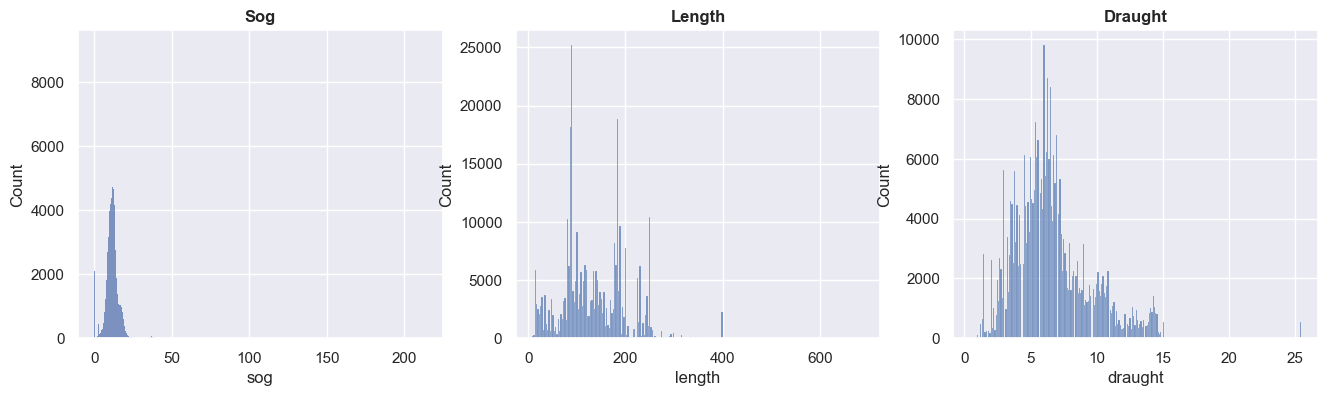

In [17]:
outlier_cols = ['sog', 'length', 'draught']

fig, axes = plt.subplots(1, 3, figsize=(16,4))

for i, col in enumerate(outlier_cols):
    ax1 = sns.histplot(df[col], ax=axes[i])
    ax1.set_title(col.capitalize(), weight='bold')

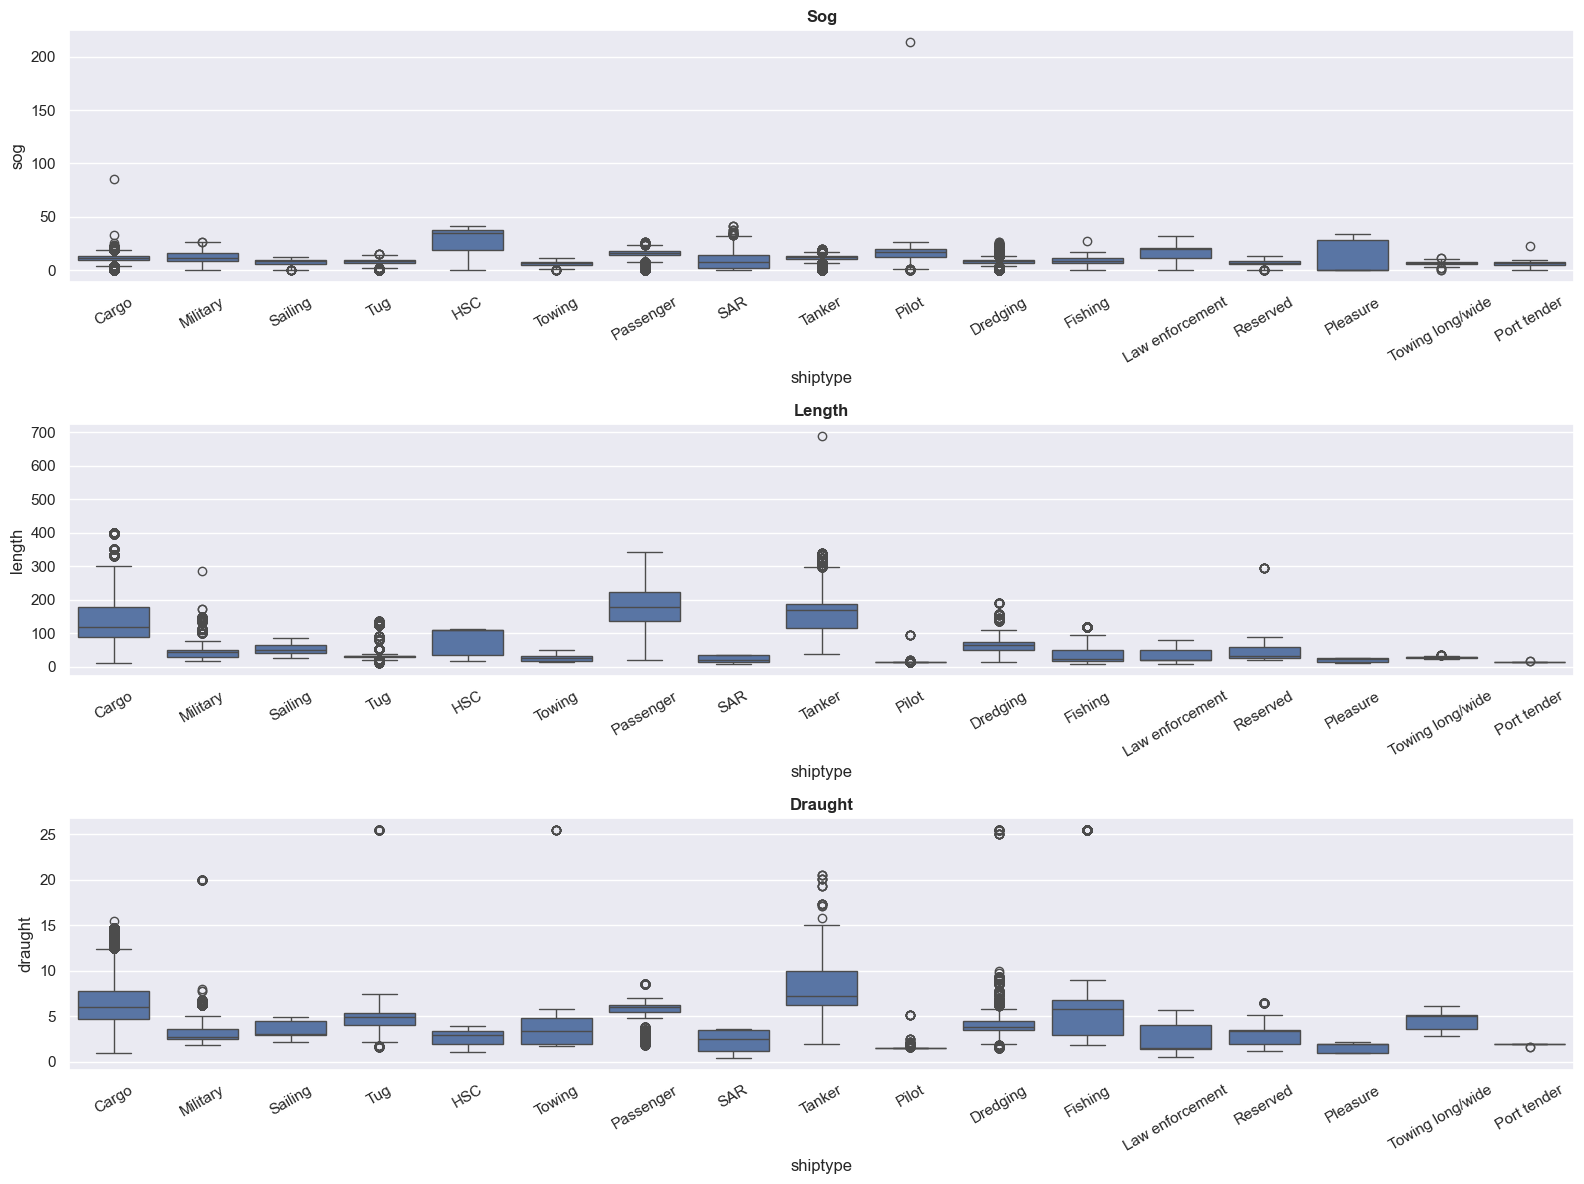

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(16,12))


for i, col in enumerate(outlier_cols):
    ax = sns.boxplot(data=df, x='shiptype', y=col, ax=axes[i])
    ax.set_title(col.capitalize(), weight='bold')
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
plt.tight_layout()

In [19]:
# Potential rows to remove
df[(df.sog>200)|(df.length>500)]

,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,area
76551,211422510,Under way using engine,13.9,134.5,133.0,Tanker,28.0,690.0,6.8,19320.0
330195,219023648,Under way using engine,214.0,343.7,356.0,Pilot,5.0,15.0,1.5,75.0


In [20]:
df = df[(df.sog<=200)|(df.length<=500)]

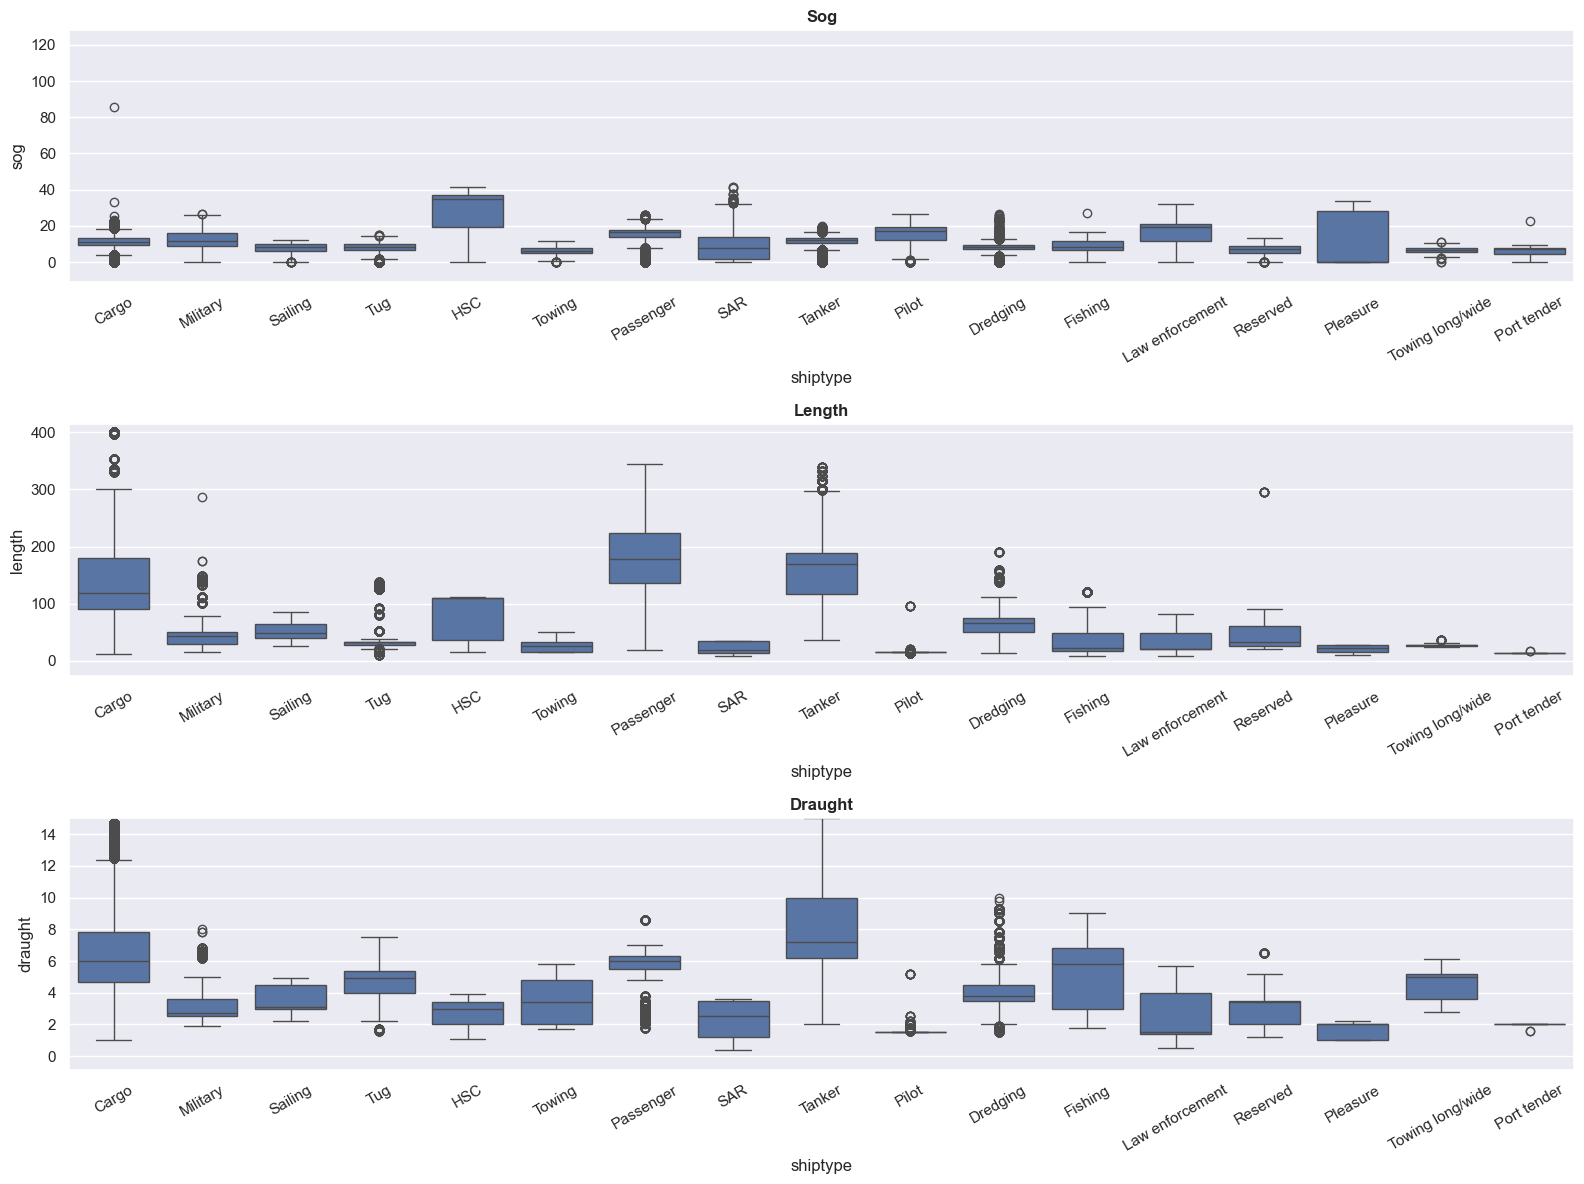

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(16,12))


for i, col in enumerate(outlier_cols):
    ax = sns.boxplot(data=df, x='shiptype', y=col, ax=axes[i])
    ax.set_title(col.capitalize(), weight='bold')
    ax.set_ylim(top=int(df[col].max()*.6))
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
plt.tight_layout()

In [22]:
pd.DataFrame(df.groupby(['navigationalstatus', 'shiptype']).size()).head(60)

0
navigationalstatus                                 shiptype              
At anchor                                          Cargo              227
                                                   Dredging             9
                                                   Fishing              7
                                                   Law enforcement      1
                                                   Military             7
                                                   Reserved            24
                                                   SAR                  1
                                                   Tanker             212
                                                   Towing              14
                                                   Tug                  5
Constrained by her draught                         Cargo             5228
                                                   Dredging            27
                                                   Reserved            25
                                                   Tanker            6779
Engaged in fishing                                 Dredging             1
                                                   Fishing           5370
Moored                                             Cargo             1087
                                                   Dredging            88
                                                   Fishing            148
                                                   HSC                138
                                                   Law enforcement     21
                                                   Military           412
                                                   Passenger          221
                                                   Pilot               92
                                                   Pleasure            46
                                                   Port tender         52
                                                   Reserved            51
                                                   SAR                125
                                                   Sailing             14
                                                   Tanker             362
                                                   Towing              30
                                                   Towing long/wide     2
                                                   Tug                333
Not under command                                  Cargo                1
                                                   Military             1
                                                   Passenger            1
                                                   Tanker               1
                                                   Tug                  1
Power-driven vessel pushing ahead or towing alo... Cargo                1
                                                   Tug                234
Power-driven vessel towing astern                  Tug                246
Reserved for future amendment [HSC]                Fishing             87
                                                   HSC               1644
Restricted maneuverability                         Cargo                6
                                                   Dredging           181
                                                   Law enforcement     12
                                                   Military            18
                                                   Pilot                4
                                                   Reserved            72
                                                   SAR                  1
                                                   Towing             290
                                                   Towing long/wide   340
                                                   Tug                743
Un

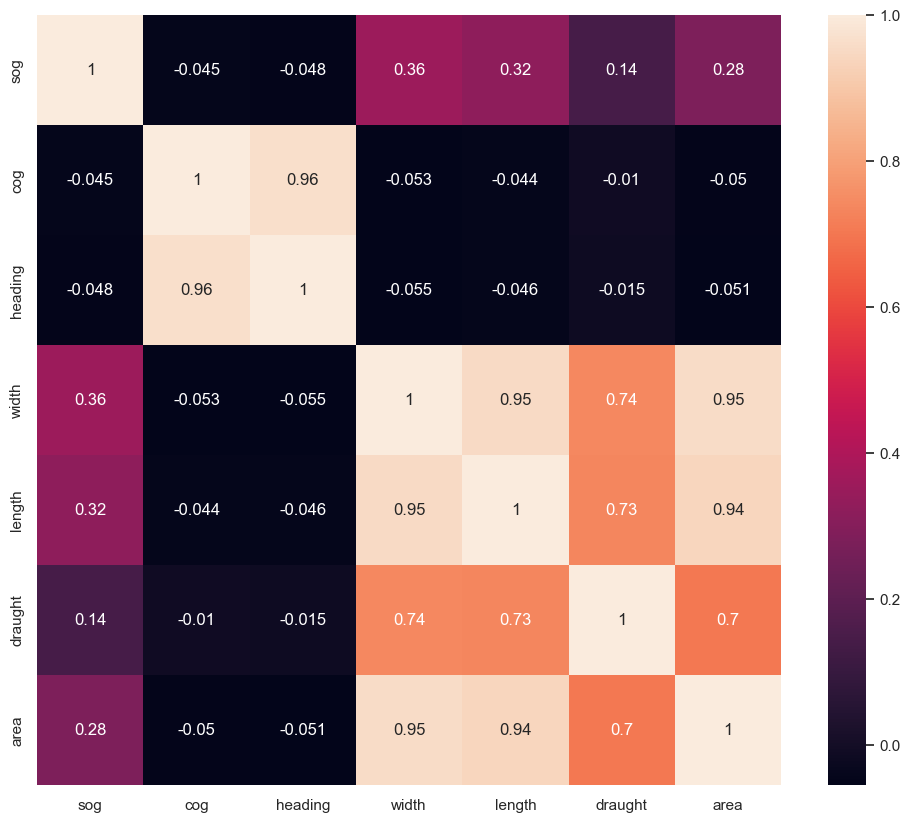

In [23]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()[1:]

plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_columns].corr(), annot=True)
plt.show()

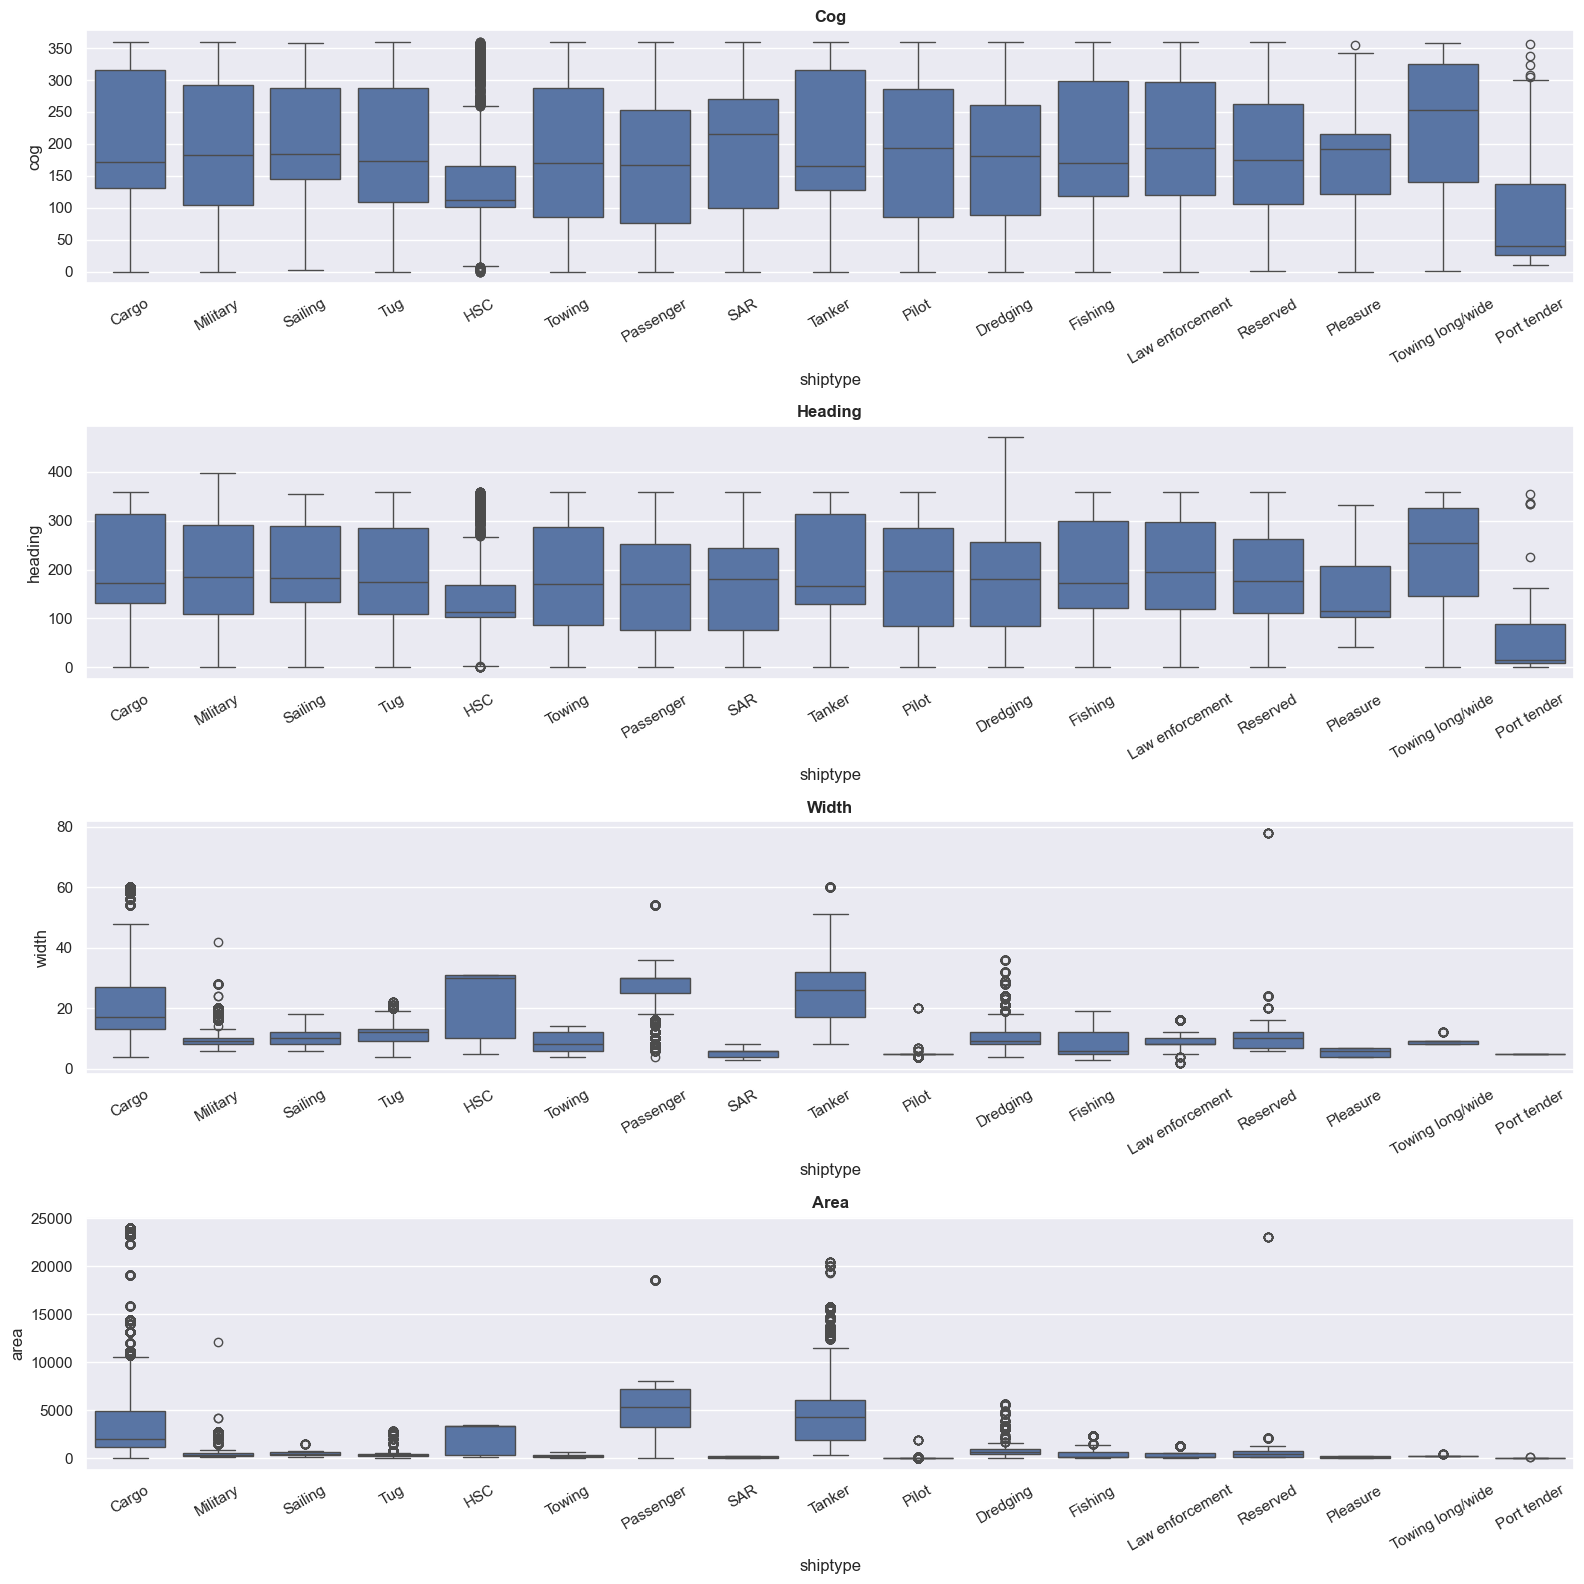

In [24]:
remaining_vars = ['cog', 'heading', 'width', 'area']

fig, axes = plt.subplots(4, 1, figsize=(16,16))


for i, col in enumerate(remaining_vars):
    ax = sns.boxplot(data=df, x='shiptype', y=col, ax=axes[i])
    ax.set_title(col.capitalize(), weight='bold')
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
plt.tight_layout()

In [25]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

for_pca = df.dropna().sample(20000)

# Scale data
scaler = MinMaxScaler()

scaled_df = pd.DataFrame(scaler.fit_transform(for_pca[numeric_cols]), columns=numeric_cols)

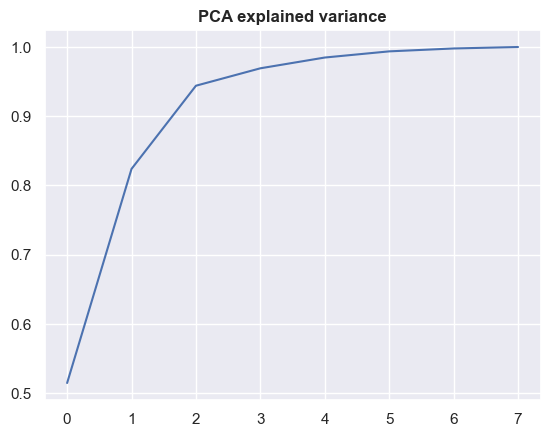

In [26]:
# PCA
pca = PCA()
pca_df = pd.DataFrame(pca.fit_transform(scaled_df), 
             columns=[f'PCA{n+1}' for n in range(pca.fit_transform(scaled_df).shape[1])])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA explained variance', weight='bold')
plt.show()

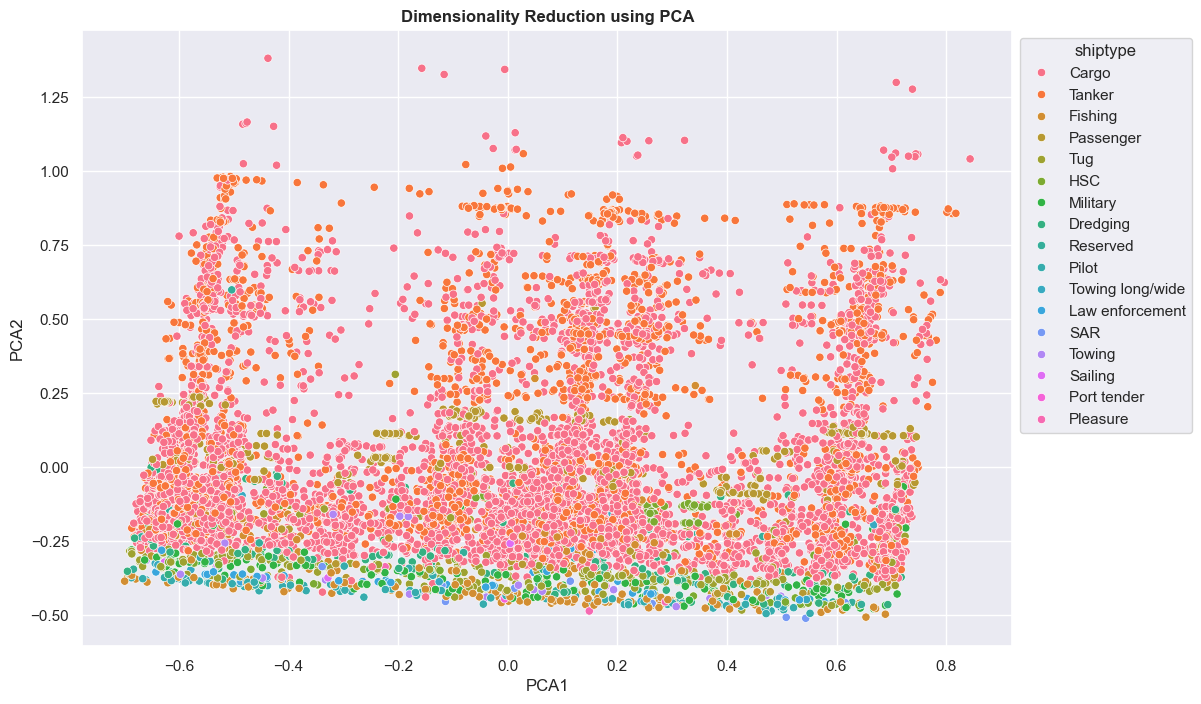

In [27]:
pca_df_out = pd.concat([pca_df, for_pca['shiptype'].reset_index()], axis=1)
plt.figure(figsize=(12,8))
ax = sns.scatterplot(data=pca_df_out.sample(10000), x='PCA1', y='PCA2', hue='shiptype', legend=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Dimensionality Reduction using PCA', weight='bold')

plt.show()

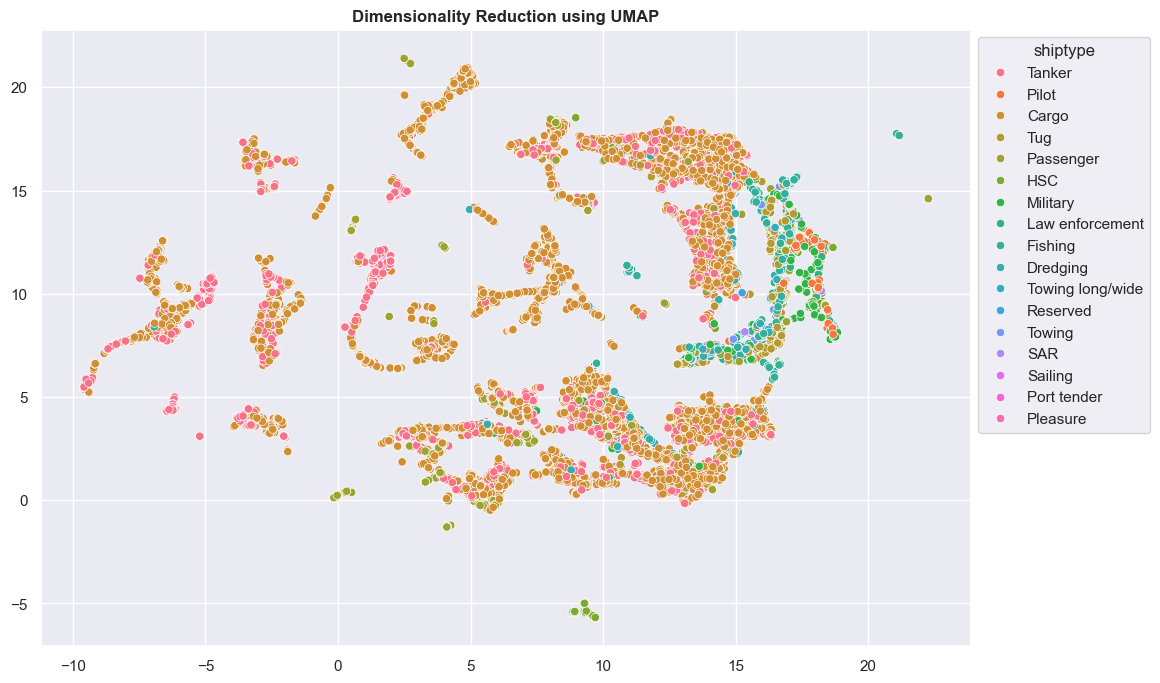

In [28]:
reducer = umap.UMAP()
umap_reduced = reducer.fit_transform(scaled_df)
plt.figure(figsize=(12,8))

ax = sns.scatterplot(x=umap_reduced[:,0], y=umap_reduced[:,1], hue=for_pca.shiptype, legend=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Dimensionality Reduction using UMAP', weight='bold')

plt.show()

In [29]:
df.shiptype

4             Cargo
5             Cargo
7             Cargo
8             Cargo
11         Military
            ...    
358345       Tanker
358346        Cargo
358347        Cargo
358348    Passenger
358350      Fishing
Name: shiptype, Length: 324561, dtype: object

In [30]:
# Define the resposne variable
response = 'shiptype'

# One-hot encode thee categorical columns
cat_col = ['navigationalstatus']
dummies = pd.get_dummies(df[cat_col], dtype=int)
processed_df = pd.concat([df, dummies], axis=1).drop(cat_col, axis=1)

# Rename column with non-standard characters
processed_df = processed_df.rename(columns={'navigationalstatus_Reserved for future amendment [HSC]':'navigationalstatus_Reserved for future amendment'})

In [31]:
# Serving set to be kept completely left out of the cross validation and model tuning process to bee used as final validation.
np.random.seed(1)
mmsi_validation = np.random.choice(processed_df.mmsi.unique(), int(len(processed_df.mmsi.unique())*.1))

# Scale data
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(processed_df.drop([response, 'mmsi'], axis=1))
scaled_df = pd.DataFrame(scaled_df, columns=processed_df.drop([response, 'mmsi'], axis=1).columns)
scaled_df = pd.concat([scaled_df, processed_df[[response, 'mmsi']].reset_index(drop=True)], axis=1)

# Encode the response variable
encoder = LabelEncoder()
scaled_df['shiptype_encode'] = encoder.fit_transform(scaled_df[response])

# Split training and serving df
serving_df = scaled_df[scaled_df.mmsi.isin(mmsi_validation)]
train_df = scaled_df[~scaled_df.mmsi.isin(mmsi_validation)]
# Check we have representation between the classes
serving_df.shiptype.value_counts()

shiptype
Cargo               21876
Tanker               9310
Fishing               708
Dredging              673
Military              523
Pilot                 480
Passenger             271
Tug                   115
HSC                    82
Sailing                15
Towing long/wide        1
Name: count, dtype: int64

In [32]:
serving_df.shiptype_encode.value_counts()

shiptype_encode
0     21876
13     9310
2       708
1       673
5       523
7       480
6       271
16      115
3        82
12       15
15        1
Name: count, dtype: int64

In [33]:
response = 'shiptype_encode'
drop_cols = [response, 'mmsi', 'shiptype']

X = train_df.drop(drop_cols, axis=1)
y = train_df[response]

X_serving = serving_df.drop(drop_cols, axis=1)
y_serving = serving_df[response]

In [34]:
## Split train and test
np.random.seed(1)
mmsi_test = np.random.choice(train_df.mmsi.unique(), int(len(train_df.mmsi.unique())*.2))

# Ensure train and test do not contain the same vessel
test = train_df[train_df.mmsi.isin(mmsi_test)]
train = train_df[~train_df.mmsi.isin(mmsi_test)]

X = train.drop(drop_cols, axis=1)
y = train[response]

X_test = test.drop(drop_cols, axis=1)
y_test = test[response]

In [35]:
# Define classifiers to test
classifiers = [
    RandomForestClassifier(),
    MLPClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    xgb.XGBClassifier()
]

In [36]:
bal_acc_res = list()
acc_res = list()

# Train and log results for each of the classifiers
for mod in classifiers:
    t1 = time.time()
    
    try:
        print(f"Training classifier: {mod}")
        mod.fit(X, y)
        pred = mod.predict(X_test)
        bal_acc = balanced_accuracy_score(y_test, pred)
        acc = accuracy_score(y_test, pred)
        bal_acc_res.append(bal_acc)
        acc_res.append(acc)
        print(f"Balanced accuracy: {bal_acc}, accuracy: {acc}, time to train model: {time.time()-t1}")

    except Exception as e:
        print(e)
        print(f"Error in {mod}")

Training classifier: RandomForestClassifier()
Balanced accuracy: 0.5481736380214752, accuracy: 0.8484439191850977, time to train model: 16.390901803970337
Training classifier: MLPClassifier()
Balanced accuracy: 0.5120191440858158, accuracy: 0.773669499315287, time to train model: 1778.4904630184174
Training classifier: GradientBoostingClassifier()
Balanced accuracy: 0.4559041678004057, accuracy: 0.7783780741741235, time to train model: 316.0548520088196
Training classifier: GaussianNB()
Balanced accuracy: 0.20406082456473137, accuracy: 0.12495544675183372, time to train model: 0.16661596298217773
Training classifier: LinearDiscriminantAnalysis()
Balanced accuracy: 0.23513577514782966, accuracy: 0.6201249366874895, time to train model: 0.17769217491149902
Training classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              

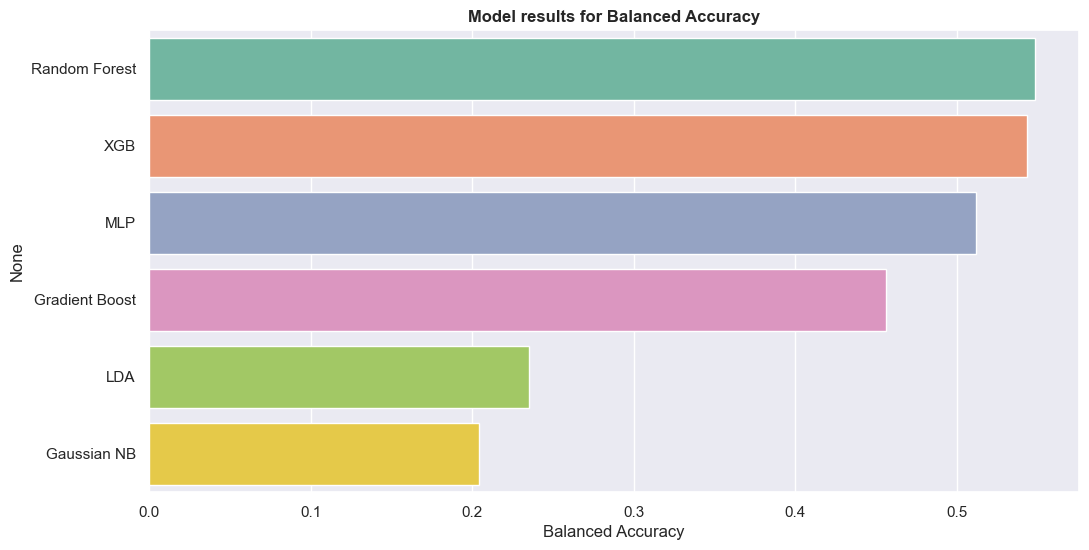

In [37]:
names = [
    'Random Forest',
    'MLP',
    'Gradient Boost',
    'Gaussian NB',
    'LDA',
    'XGB'
]

results = pd.DataFrame(bal_acc_res, index=names)

results = results.set_axis(['Balanced Accuracy'], axis=1, copy=False).sort_values(by='Balanced Accuracy', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=results['Balanced Accuracy'], y=results.index, palette='Set2')
plt.title('Model results for Balanced Accuracy', weight='bold')

plt.show()

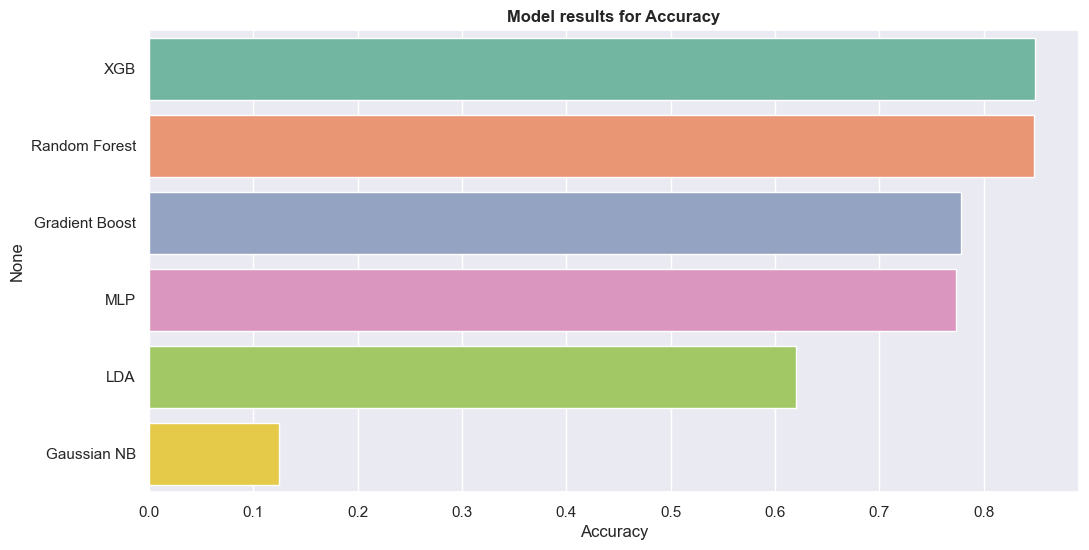

In [38]:
results = pd.DataFrame(acc_res, index=names)

results = results.set_axis(['Accuracy'], axis=1, copy=False).sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=results['Accuracy'], y=results.index, palette='Set2')
plt.title('Model results for Accuracy', weight='bold')


plt.show()

In [39]:
import time
# Define model hyperparameter function
def tune_best_model(train_df: pd.DataFrame, 
                    params: dict[str, Any],
                    drop_cols: list[str],
                    response: str = 'shiptype_encode', 
                    group: str = 'mmsi',
                    scoring_metric: str = 'balanced_accuracy') -> dict[str, Any]:
    """Function to tune model and return best results and params

    Args:
        train_df (pd.DataFrame): Training data
        params (dict[str, Any]): Parameters to tune
        drop_cols (list[str]): Columns to drop
        response (str, optional): Response variable. Defaults to 'shiptype_encode'.
        group (str, optional): Variable to use for the grouped k-fold. 
        Defaults to 'mmsi'.
        scoring_metric (str, optional): Performance metric. Defaults to 'balanced_accuracy'.

    Returns:
        dict[str, Any]: results dictionary
    """    
    since = time.time()
    # Define groups for group k-fold
    groups = train_df[group]

    X = train_df.drop(drop_cols, axis=1)
    y = train_df[response]

    # Grouped 5-fold CV
    gkf = GroupKFold(n_splits=5)
    gkf.get_n_splits(X, y, groups)

    print(f"Tuning models for {response} with {len(train_df)} training rows")

    # Define sample weights since we are dealing with a significant imbalance between classes
    samp_weights = compute_sample_weight(class_weight='balanced', y=y)

    rf_cv = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid=params,
        cv=gkf,
        verbose=10,
        scoring=scoring_metric,
    )

    rf_cv.fit(X, y, groups=groups, sample_weight=samp_weights)

    results = dict(
        {
            f"scores_{response}": rf_cv.best_score_,
            f"params_{response}": rf_cv.best_params_
        }
    )
    elapsed_time = time.time() - since
    print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
    return results

In [40]:
params = {'max_depth': [None, 4,5,6, 7, 8, 9, 10],
         'n_estimators': [50, 100, 200]}

results = tune_best_model(train_df, params=params, drop_cols=drop_cols)

Tuning models for shiptype_encode with 290507 training rows
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 1/5; 1/24] END max_depth=None, n_estimators=50;, score=0.566 total time=   8.8s
[CV 2/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 2/5; 1/24] END max_depth=None, n_estimators=50;, score=0.459 total time=   8.3s
[CV 3/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 3/5; 1/24] END max_depth=None, n_estimators=50;, score=0.514 total time=   8.6s
[CV 4/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 4/5; 1/24] END max_depth=None, n_estimators=50;, score=0.373 total time=   8.4s
[CV 5/5; 1/24] START max_depth=None, n_estimators=50............................
[CV 5/5; 1/24] END max_depth=None, n_estimators=50;, score=0.432 total time=   8.5s
[CV 1/5; 2/24] START max_depth=None, n_estimators=100

In [41]:
best_params = {'max_depth': 9, 'n_estimators': 50}

In [42]:
X = train_df.drop(drop_cols, axis=1)
y = train_df[response]

samp_weights = compute_sample_weight(class_weight='balanced', y=y)
mod = RandomForestClassifier(**best_params)
mod.fit(X, y, samp_weights)

RandomForestClassifier(max_depth=9, n_estimators=50)

In [43]:
X_serving = serving_df.drop(drop_cols, axis=1)
y_serving = serving_df[response]

In [44]:
preds = mod.predict(X_serving)
probs = mod.predict_proba(X_serving)
acc = accuracy_score(y_serving, preds)
bal_acc = balanced_accuracy_score(y_serving, preds)

print(f"Results on serving set, balanced accuracy={bal_acc}, accuraqcy={acc}")

Results on serving set, balanced accuracy=0.5401737250708423, accuraqcy=0.5985493627767663


In [45]:
acc = accuracy_score(y_serving, preds)
bal_acc = balanced_accuracy_score(y_serving, preds)

print(f"Results on serving set, balanced accuracy={bal_acc}, accuraqcy={acc}")

Results on serving set, balanced accuracy=0.5401737250708423, accuraqcy=0.5985493627767663


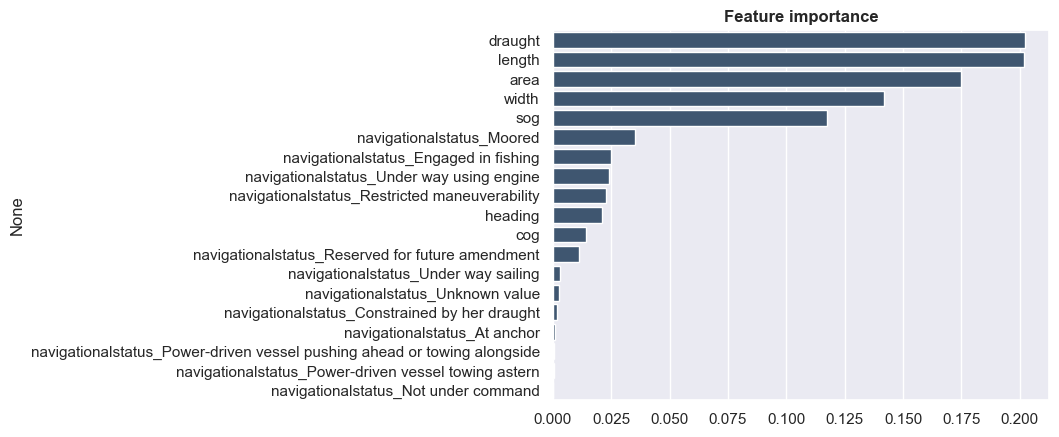

In [46]:
# Extract feature importance
feat_imp = pd.Series(mod.feature_importances_, X.columns).sort_values(
    ascending=False
)
# # Remove columns which provide no benefit to the model
# feat_imp = feat_imp[feat_imp > 0.01]
feat_df = pd.DataFrame(feat_imp.values, feat_imp.index)

sns.barplot(x=feat_imp.values, y=feat_imp.index, color="#375578")
plt.title(f"Feature importance", weight="bold")
plt.show()

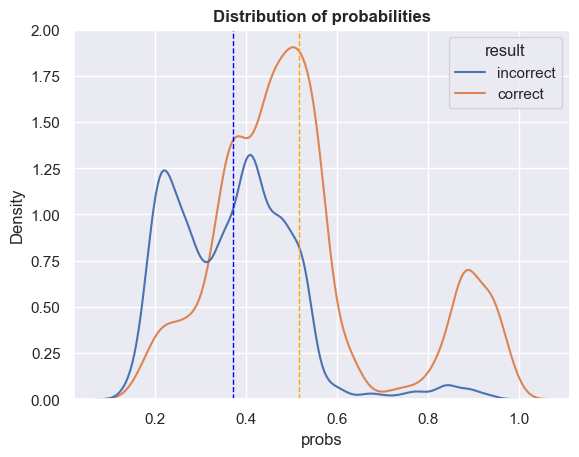

In [47]:
results_df = pd.DataFrame(
            {
                "ground_truth": serving_df[response],
                "ground_truth_orig": serving_df['shiptype'],
                "pred": preds,
                "probs": [prob[pred] for (pred, prob) in zip(preds, probs)]
            }
        )

results_df['result'] = results_df.apply(lambda x: 'correct' if x.ground_truth==x.pred else 'incorrect', axis=1)

sns.kdeplot(data=results_df, x="probs", hue='result')
plt.axvline(results_df[results_df.result=='correct'].probs.mean(), c="orange", ls="--", lw=1)
plt.axvline(results_df[results_df.result=='incorrect'].probs.mean(), c="blue", ls="--", lw=1)
plt.title("Distribution of probabilities", weight="bold")
plt.show()

In [48]:
acc_list = list()

for ship in results_df.ground_truth_orig.unique():
    ship_res = results_df[results_df.ground_truth_orig==ship]
    acc = accuracy_score(ship_res.ground_truth, ship_res.pred)
    acc_list.append(acc)

    print(f"Results for {ship}, accuracy:{round(acc, 2)}, count:{len(ship_res)}")

Results for Cargo, accuracy:0.53, count:21876
Results for Military, accuracy:0.2, count:523
Results for Tanker, accuracy:0.71, count:9310
Results for HSC, accuracy:0.59, count:82
Results for Pilot, accuracy:1.0, count:480
Results for Passenger, accuracy:0.89, count:271
Results for Dredging, accuracy:0.87, count:673
Results for Fishing, accuracy:0.79, count:708
Results for Towing long/wide, accuracy:0.0, count:1
Results for Tug, accuracy:0.37, count:115
Results for Sailing, accuracy:0.0, count:15


In [49]:
results

{'scores_shiptype_encode': 0.5041368273825764,
 'params_shiptype_encode': {'max_depth': 10, 'n_estimators': 100}}

In [50]:
df

,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,area
4,212584000,Moored,0.0,153.0,106.0,Cargo,13.0,99.0,6.3,1287.0
5,636020662,At anchor,0.1,43.9,286.0,Cargo,23.0,149.0,6.3,3427.0
7,246539000,At anchor,0.0,3.8,293.0,Cargo,16.0,150.0,6.8,2400.0
8,210307000,Moored,0.0,285.1,225.0,Cargo,16.0,90.0,5.2,1440.0
11,219263000,Moored,0.0,353.9,100.0,Military,12.0,48.0,4.2,576.0
...,...,...,...,...,...,...,...,...,...,...
358345,266475000,Under way using engine,11.2,92.4,90.0,Tanker,17.0,120.0,6.7,2040.0
358346,236125000,Under way using engine,11.0,171.9,169.0,Cargo,12.0,82.0,4.2,984.0
358347,209717000,Under way using engine,16.6,341.6,343.0,Cargo,27.0,170.0,8.9,4590.0
358348,257182000,Under way using engine,20.6,340.7,341.0,Passenger,36.0,224.0,6.9,8064.0


In [51]:
results = pd.DataFrame(acc_list, index=results_df.ground_truth_orig.unique())
results = results.set_axis(['Accuracy'], axis=1, copy=False).sort_values(by='Accuracy', ascending=False)

count_all = list()
count_serving = list()

for ship in results.index:
    count_all.append(len(df[df.shiptype==ship]))
    count_serving.append(len(results_df[results_df.ground_truth_orig==ship]))

results['count_all'] = count_all
results['count_serving'] = count_serving

results

,Accuracy,count_all,count_serving
Pilot,1.000000,2902,480
Passenger,0.885609,16778,271
Dredging,0.873700,5109,673
Fishing,0.788136,12110,708
Tanker,0.712567,77405,9310
HSC,0.585366,3694,82
Cargo,0.534376,186699,21876
Tug,0.365217,9410,115
Military,0.196941,6073,523
Towing long/wide,0.000000,586,1


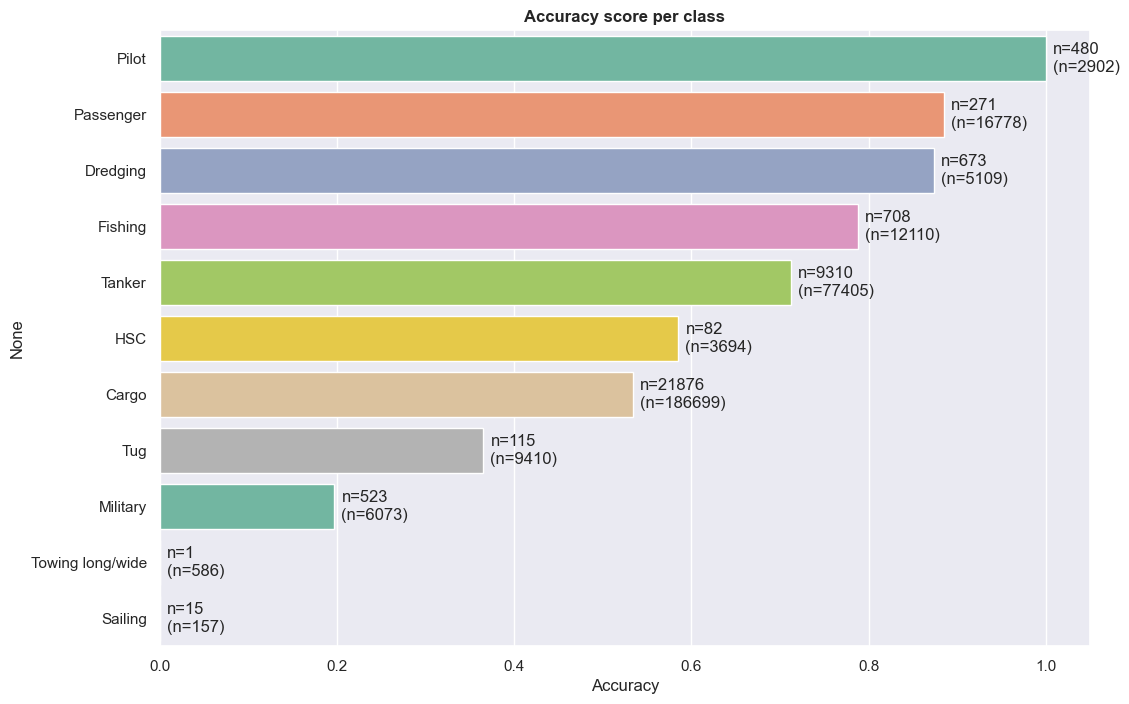

In [52]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x=results['Accuracy'], y=results.index, palette='Set2')

for p, count, count_train in zip(ax.patches, results.count_serving,results.count_all):
    ax.annotate(f"n={count}\n(n={count_train})", xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

plt.title('Accuracy score per class', weight='bold')

plt.show()

In [53]:
import joblib
import os

# Define model save path
save_dir = "../model_utils/kattegat_jan_mar"
os.makedirs(save_dir, exist_ok=True)

# Save all trained models
model_names = ['random_forest', 'mlp', 'gradient_boost', 'gaussian_nb', 'lda', 'xgb']
for name, model in zip(model_names, classifiers):
    try:
        joblib.dump(model, os.path.join(save_dir, f"{name}_model.pkl"))
        print(f"✅ Saved {name}_model.pkl")
    except Exception as e:
        print(f"❌ Failed to save {name}: {e}")

# Save pre-processing components
joblib.dump(scaler, os.path.join(save_dir, "scaler.pkl"))
joblib.dump(encoder, os.path.join(save_dir, "label_encoder.pkl"))

print("\n✅ All models and preprocessing components saved to models/model_utils/")


✅ Saved random_forest_model.pkl
✅ Saved mlp_model.pkl
✅ Saved gradient_boost_model.pkl
✅ Saved gaussian_nb_model.pkl
✅ Saved lda_model.pkl
✅ Saved xgb_model.pkl

✅ All models and preprocessing components saved to models/model_utils/
